In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2D, GlobalAveragePooling2D, MaxPooling2D
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset',
    label_mode='binary',
    batch_size=32,
    image_size=(64, 64),
    interpolation='area',
    shuffle=True,
    seed=123
)

import numpy as np
def process(x, y):
    x/=256.0
    return (x, y)
normalized_ds = train_dataset.map(process)

AUTOTUNE = tf.data.AUTOTUNE

dataset = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE).shuffle(100)

Found 16182 files belonging to 2 classes.


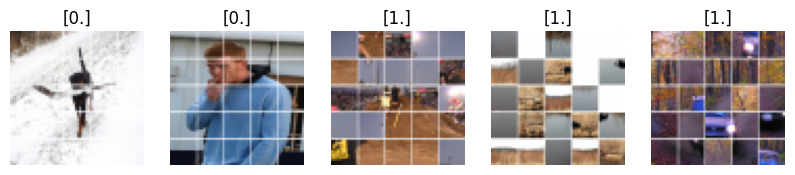

In [4]:
def imshow():    
    n = 5
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(n):
            img = images[i]
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(img, cmap='gist_gray')
            plt.axis('off')
            plt.title(str(labels.numpy()[i]))
            ax.get_yaxis().set_visible(False)           
    plt.show()
imshow()

In [5]:
inputs = Input(shape=(64, 64, 3))
x = Reshape((64,64,3))(inputs)
x = Conv2D(32, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(64, 3, activation = 'relu', strides = 2, padding = 'same')(x)
x = Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
x = MaxPooling2D(2)(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
x = MaxPooling2D(2)(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(1, activation = 'sigmoid')(x)
outputs = x
cnn = keras.Model(inputs, outputs)


In [ ]:
cnn.summary()

In [6]:
class Model(tf.keras.Model):
    def __init__(self, nn):
        super(Model, self).__init__()
        self.nn = nn
        
    def get_loss(self, y, preds):
        loss = tf.keras.losses.BinaryCrossentropy()(y, preds)
        return loss
        
    @tf.function
    def training_step(self, x , y):
        with tf.GradientTape() as tape:
            
            preds = self.nn(x)
            loss = self.get_loss(y, preds)
            
        gradients = tape.gradient(loss, self.nn.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.nn.trainable_variables))
        return tf.reduce_mean(loss)   

In [7]:
model = Model(cnn)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

In [ ]:
for x, y in dataset.take(1):
    print(model.training_step(x, y))

In [ ]:
from IPython.display import clear_output
hist = np.array(np.empty([0]))
epochs = 100
for epoch in range(1, epochs + 1):
    loss = 0
    for step, (x, y) in enumerate(dataset):
        loss+=model.training_step(x, y)
    clear_output(wait=True)
    print(epoch)
    hist = np.append(hist, loss)
    plt.plot(np.arange(0,len(hist)), hist)
    plt.show()


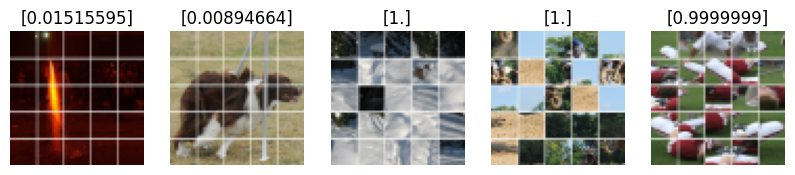

In [10]:
def imshow_and_pred():    
    n = 5
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        res = model.nn(images)
        for i in range(n):
            img = images[i]
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(img, cmap='gist_gray')
            plt.axis('off')
            plt.title(str(res.numpy()[i]))
        
    plt.show()
imshow_and_pred()

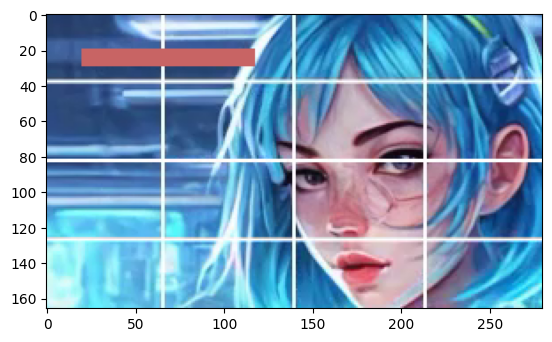

In [27]:
import cv2
cap = cv2.VideoCapture("anime test.mp4")
maxval = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    img_tensor = tf.expand_dims(frame, axis = 0)
    img_tensor = tf.cast(img_tensor, tf.float32) / 255
    img_tensor = tf.image.resize(img_tensor, (64, 64), method='area')
    
    res = model.nn(img_tensor)
    
    dog_bar = round((1 - res.numpy()[0][0])*100)
    if (maxval < (1 - res.numpy()[0][0])):
        maxval = (1 - res.numpy()[0][0])
        result = frame
    frame[20:30, 20: 20+dog_bar, :] = np.full((10, dog_bar, 3), [100,100,200])
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(result)

In [ ]:
model.nn.save("cnn_model.h5")

In [8]:
model.nn.load_weights("cnn_model.h5")